## MovieLens dataset preprocessing

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt


def preprocess(datasetPath = './ratings.dat'):
    # PLEASE DELETE THIS LINE LATER: nrows took first 500000 rows for test 
    rating_dataset = pd.read_csv(datasetPath,sep='::')
    
    rating_dataset.columns = ['user_id','item_id','rating','timestamp']
    print(rating_dataset.describe())
    

    
    min_rating = rating_dataset['rating'].min()
    max_rating = rating_dataset['rating'].max()

    # if the rating is greater or equal to 4, treat it as positive rating (1); 
    # otherwise treat it as negative rating (0)
    #rating_dataset.loc[:,'rating'] = rating_dataset['rating'].map(lambda x: 1 if x >= 4 else 0)
    rating_dataset.loc[:,'rating'] = rating_dataset['rating'].map(lambda x: (x - min_rating) / (max_rating - min_rating))
    
    # store the original user_id and item_id lists
    user_id_list = sorted(rating_dataset.loc[:,'user_id'].unique().tolist())
    item_id_list = sorted(rating_dataset.loc[:,'item_id'].unique().tolist())

    item_index = np.arange(len(item_id_list)).tolist()
    

    # set the initial value (rating) of all the entries as 0 (if the data is NA, leave it as 0)
    # user_item_matrix = np.zeros(shape = (len(user_id_list), len(item_id_list)))

    # The (i row, j column) of user_item_matrix means the ith user's rating to the jth movies, 
    # Here, i and j are the actual ids' indices in the user_id_list and item_id_list respectively.

    # for i in range(len(user_id_list)):
    #     for index, row in rating_dataset.groupby(['user_id']).get_group(user_id_list[i]).iterrows():
    #         item_id = row['item_id']
    #         rating = row ['rating']
    #         user_item_matrix[i, item_id_list.index(item_id)] = rating

    user_item_matrix = rating_dataset.pivot(index='user_id', columns='item_id', values='rating')
    user_item_matrix = np.float32(user_item_matrix.fillna(0).to_numpy())
    print(user_item_matrix)
    print(user_item_matrix.shape)

    # show the sparsity of the user-item matrix
    
    sparsity = 1.0 - ( np.count_nonzero(user_item_matrix) / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) )
    sparsity *= 100
    print('{:.2f}%'.format(sparsity))
    
    return rating_dataset, user_id_list, item_id_list, user_item_matrix

rating_dataset, user_id_list, item_id_list, user_item_matrix = preprocess(datasetPath = './ratings.dat')

/tmp/ipykernel_1289640/3430766284.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  rating_dataset = pd.read_csv(datasetPath,sep='::')


            user_id       item_id        rating     timestamp
count  1.000005e+07  1.000005e+07  1.000005e+07  1.000005e+07
mean   3.586986e+04  4.120292e+03  3.512422e+00  1.032606e+09
std    2.058534e+04  8.938402e+03  1.060418e+00  1.159640e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    1.812300e+04  6.480000e+02  3.000000e+00  9.467659e+08
50%    3.574100e+04  1.834000e+03  4.000000e+00  1.035476e+09
75%    5.360800e+04  3.624000e+03  4.000000e+00  1.126749e+09
max    7.156700e+04  6.513300e+04  5.000000e+00  1.231132e+09
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(69878, 10677)
98.67%


## Train/Test dataset split

In [21]:
def train_test_split(ratings):
    test_time = np.quantile(rating_dataset.timestamp, 0.90)
    test_ids = rating_dataset.loc[rating_dataset['timestamp'] > test_time, ['user_id', 'item_id']]\
            .groupby('user_id')
    
    
    test_index_list = []


    for uid, mids in test_ids.__iter__():
        u_index = user_id_list.index(uid)
        mid_list = mids.item_id.to_list()
        movie_indices = [item_id_list.index(mid) for mid in mid_list]
    
        test_index_list.append({u_index:movie_indices})
        
    
    test = np.zeros(ratings.shape)
   
    
    train = ratings.copy()
    for i in test_index_list:
        for u_index, m_list in i.items():
            train[u_index, m_list] = 0
            test[u_index, m_list] = ratings[u_index, m_list]
            
    validation = np.zeros(ratings.shape)
    
    MIN_USER_RATINGS = 35
    DELETE_RATING_COUNT = 15
    DELETE_RATING_COUNT_PROPORTION = 0.2
 
    for user in np.arange(ratings.shape[0]):
    
        if len(train[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            # if this user has rated more than MIN_USER_RATINGS=35 movies
            # delete DELETE_RATING_COUNT=15 of the ratings
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=int(DELETE_RATING_COUNT_PROPORTION*len(ratings[user,:].nonzero()[0])),
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]

    return train, validation, test



In [22]:
train, val, test = train_test_split(user_item_matrix)
print("ratings shape", user_item_matrix.shape, " number of nonzero:", np.count_nonzero(user_item_matrix))
print("training shape", train.shape, " number of nonzero:", np.count_nonzero(train))
print("validation shape", val.shape, " number of nonzero:", np.count_nonzero(val))
print("test shape", test.shape, " number of nonzero:", np.count_nonzero(test))

ratings shape (69878, 10677)  number of nonzero: 9905065
training shape (69878, 10677)  number of nonzero: 7239933
validation shape (69878, 10677)  number of nonzero: 1719720
test shape (69878, 10677)  number of nonzero: 981615


In [23]:
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

## Matrix Factorization

In [24]:

class Recommender:
  
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.01):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
      
        for u, i in zip(users, items):       
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
        print("Now the epoch number is:", epoch)
        print("The RMSE of training set is: ", self.train_error[-1])
        print("The RMSE of validation set is: ", self.val_error[-1])
        print(" ")
    
    return self

    
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
 
    return y_hat[user_index, predictions_index].flatten()

In [25]:
recommender = Recommender(n_epochs = 50, n_latent_features = 3).fit(train, val)
print("The RMSE of training set is: ", recommender.train_error[-1])
print("The RMSE of validation set is: ", recommender.val_error[-1])

 




Now the epoch number is: 0
The RMSE of training set is:  0.43541819118556374
The RMSE of validation set is:  0.4865742026111709
 


IOStream.flush timed out


Now the epoch number is: 1
The RMSE of training set is:  0.3736379258651081
The RMSE of validation set is:  0.41417289846961014
 
Now the epoch number is: 2
The RMSE of training set is:  0.3471216613801027
The RMSE of validation set is:  0.3813058754578572
 
Now the epoch number is: 3
The RMSE of training set is:  0.3294216488699514
The RMSE of validation set is:  0.3590762583783267
 
Now the epoch number is: 4
The RMSE of training set is:  0.3155080511069523
The RMSE of validation set is:  0.34175107271547955
 


IOStream.flush timed out


Now the epoch number is: 5
The RMSE of training set is:  0.30369422867033513
The RMSE of validation set is:  0.32736614557059607
 
Now the epoch number is: 6
The RMSE of training set is:  0.29326972573614574
The RMSE of validation set is:  0.315058530790682
 
Now the epoch number is: 7
The RMSE of training set is:  0.28389011145298537
The RMSE of validation set is:  0.304374656057221
 
Now the epoch number is: 8
The RMSE of training set is:  0.2753720697521234
The RMSE of validation set is:  0.2950383574084489
 
Now the epoch number is: 9
The RMSE of training set is:  0.26761074426324327
The RMSE of validation set is:  0.286858776916691
 
Now the epoch number is: 10
The RMSE of training set is:  0.2605420291954944
The RMSE of validation set is:  0.2796905096767077
 
Now the epoch number is: 11
The RMSE of training set is:  0.25412354570463497
The RMSE of validation set is:  0.273415445044239
 
Now the epoch number is: 12
The RMSE of training set is:  0.24832409446310671
The RMSE of val

IOStream.flush timed out
IOStream.flush timed out


Now the epoch number is: 26
The RMSE of training set is:  0.21504817246083344
The RMSE of validation set is:  0.23874854493764458
 
Now the epoch number is: 27
The RMSE of training set is:  0.21465936549347597
The RMSE of validation set is:  0.23831831584672805
 
Now the epoch number is: 28
The RMSE of training set is:  0.21436259953698034
The RMSE of validation set is:  0.23796146631640464
 
Now the epoch number is: 29
The RMSE of training set is:  0.21413820031652106
The RMSE of validation set is:  0.23766454205342244
 
Now the epoch number is: 30
The RMSE of training set is:  0.21396993385711208
The RMSE of validation set is:  0.23741648841864046
 
Now the epoch number is: 31
The RMSE of training set is:  0.21384463410181842
The RMSE of validation set is:  0.23720829015470316
 
Now the epoch number is: 32
The RMSE of training set is:  0.21375179154964133
The RMSE of validation set is:  0.2370326364810168
 
Now the epoch number is: 33
The RMSE of training set is:  0.2136831401323149


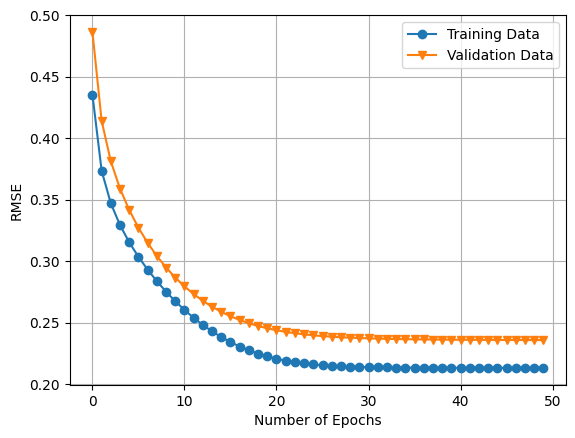

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data')
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

## AUC score of the CTR task

In [27]:
from sklearn.metrics import roc_auc_score
def map_to_CTR(matrix, nonzero):
    CTR = matrix[nonzero].flatten()
    #thres_hold = 0.8*(CTR.max()-CTR.min())
    #print(thres_hold)
    for i in range(len(CTR)):
        #if CTR[i] - CTR.min()  >= thres_hold: 
        if CTR[i] >= 0.8:
            CTR[i] = 1

        else:
            CTR[i] = 0

    return CTR

print(recommender.predictions(recommender.P, recommender.Q)[test.nonzero()].mean())
CTR_predicted_rating = map_to_CTR(recommender.predictions(recommender.P, recommender.Q),nonzero = test.nonzero())


print(test[test.nonzero()].mean())
CTR_test_rating = map_to_CTR(test, nonzero = test.nonzero())

print(CTR_predicted_rating.shape)
print(CTR_test_rating.shape)


auc_score =  roc_auc_score(CTR_test_rating, CTR_predicted_rating)
print("The auc score is", auc_score)

2.018040015781522
0.6866433959294583
(981615,)
(981615,)
The auc score is 0.5305842439432419


# Making recommendations

In [ ]:
user_id = 101
user_index = user_id_list.index(user_id)

predictions_index = np.where(train[user_index, :] == 0)[0]
print(len(predictions_index))
rating_predictions = recommender.predict(train, user_index)
rating_predictions.shape

In [ ]:
movies = pd.read_csv('movies.dat', sep='::' )
movies.columns = ['id','name', 'genres']

def create_movies_ratings(movies_df, movies_index, ratings, n=10):
  movie_ids = rating_dataset.item_id[movies_index]
  
  movie_ratings = pd.DataFrame(data=dict(id=movie_ids, rating=ratings))
  top_n_movies = movie_ratings.sort_values("rating", ascending=False).head(n)
  print(top_n_movies)
  # movie_recommendations = movies_df[movies_df.id.isin(top_n_movies.movieId)]\
  #   .reset_index(drop=True)
  # movie_recommendations['rating'] = pd.Series(top_n_movies.rating.values)
  movie_recommendations = movies_df.merge(top_n_movies, how = 'inner', on = 'id')
  return movie_recommendations.sort_values("rating", ascending=False)

In [ ]:

create_movies_ratings(movies, predictions_index, rating_predictions)